### Import Libraries

In [1]:
import os

import numpy as np
import cv2
from scipy.signal import argrelextrema
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt

#Malayalam letters mapping.
import importlib
import encoding
importlib.reload(encoding)

<module 'encoding' from '/home/alisahad/projects/repos/Malayalam-HCR/encoding.py'>

### Input image

In [31]:
image_path = 'Sample-handwritten-text-input-for-OCR.png'
image_path = 'mal-hw-2.jpeg'
inp_img = Image.open(image_path)

width,height = inp_img.size
print(height,width)

FileNotFoundError: [Errno 2] No such file or directory: 'mal-hw-2.jpeg'

### Function declarations

In [3]:
def adaptive_thresholding(image: Image, block_size=3, offset=0):
    '''
    pixels below a certain value -> black
    pixels above a certain value -> white
    '''
    grayscale_img = image.convert('L')
    img_array = np.array(grayscale_img)
    height, width = img_array.shape

    #an empty array for the output
    thresholded_image = np.zeros((height, width))
    
    for y in range(0,height, block_size):
        for x in range(0, width, block_size):
            block = img_array[y:y+block_size, x:x+block_size]
            #find the mean
            block_mean = np.mean(block)
            thresholded_block = (block > (block_mean-offset)).astype(np.uint8)*255
            thresholded_image[y:y+block_size, x:x+block_size] = thresholded_block
    return Image.fromarray(thresholded_image)

In [4]:
def negate(image):
    '''
    White background, black text -> black background, white text
    '''
    img_arr = np.array(image)
    height, width = img_arr.shape
    for y in range(height):
        for x in range(width):
            img_arr[y,x] = (img_arr[y,x]==0).astype(np.uint8)*255
    return Image.fromarray(img_arr)

In [5]:
def show(image):
    '''
    convert the image to PIL image and show.
    '''
    if isinstance(image, np.ndarray):
        Image.fromarray(image).show()
    elif isinstance(image, Image.Image):
        image.show()
    else:
        print("Can't show image.")
    

### Noise Reduction, black background

In [6]:
out_image = adaptive_thresholding(inp_img, 200, 90)
out_image.show(title='adaptive_thresholding')
out_image = negate(out_image)
out_image.show()

### Obtain bounding box coordinates

In [7]:
# Find contours and get bounding box for each contour
cnts, _ = cv2.findContours(np.array(out_image,dtype=np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = [c for c in cnts if cv2.contourArea(c)>3]
boundingBoxes = [cv2.boundingRect(c) for c in cnts]

In [8]:
def line_segmentation(image):
    '''
    Find rows of matrix with no pixels(sum of pixel values == 0)
    split the image based on these rows
    '''
    def segment(img, top, bottom):
        height,width = img.shape
        return Image.fromarray(img).crop((0,top, width, bottom))
    vertical_projection = np.sum(image, axis=1, keepdims=True)
    line_gaps = np.where(vertical_projection==0)[0]
    lines = [0]
    height, width = image.shape
    for i,y in enumerate(line_gaps):
        if i == 0: continue
        if line_gaps[i]-line_gaps[i-1]==1: continue
        lines.append(line_gaps[i])
    return [segment(image, lines[i-1], lines[i]) for i in range(1,len(lines))]

In [9]:
def apply_moving_average(profile, window_size=5):
    smoothed_profile = np.convolve(profile, )

In [10]:
# def connect_minima(img, minima_coordinates):
#     for i in range(len(minima_coordinates)-1):
#         start_point = minima_coordinates[i]

In [11]:
def find_minima(profile):
    minima_indices = argrelextrema(profile[0], np.less)
    return minima_indices

In [28]:
def trial_line(image):
    '''
    Trying out line segmentation as mentioned in the paper referenced in report 1'''
    height,width = image.shape
    print(height,width)
    num_chunks = 20
    firstquarter = num_chunks//4
    chunk_width = image.shape[1] // num_chunks
    # print(chunk_width)
    projection_profiles = []
    minima_indices = []
    for i in range(num_chunks):    
        start_col = i*chunk_width
        if i == 0:
            end_col = firstquarter*chunk_width if firstquarter!=num_chunks else image.shape[1]
        elif i<firstquarter: continue
        else:
            end_col = (i+1)*chunk_width if i!=(num_chunks-1) else image.shape[1]

        chunk_roi = image[:, start_col:end_col]
        projection_profile = np.sum(chunk_roi, axis=1)
        projection_profile = (projection_profile - np.min(chunk_roi)) / (np.max(chunk_roi) - np.min(chunk_roi))
        projection_profile = np.convolve(projection_profile, np.ones(5)/5, mode='same')
        # print(projection_profile)
        if i == 0:
            plt.plot(projection_profile[::-1],range(len(projection_profile)))
        projection_profiles.append(np.expand_dims(projection_profile, axis=0))
        # if i==0: print(projection_profiles[0])
        #Find minima of the smoothed profile
        minima_indices.append(find_minima(projection_profiles[-1]))
        # print(f"Minima indices for Chunk{i}: {minima_indices[-1]}")
    
    # print(projection_profiles[0].shape)
    final = np.concatenate(projection_profiles, axis=0)
    
    return minima_indices, firstquarter, chunk_width, final
        

494 602


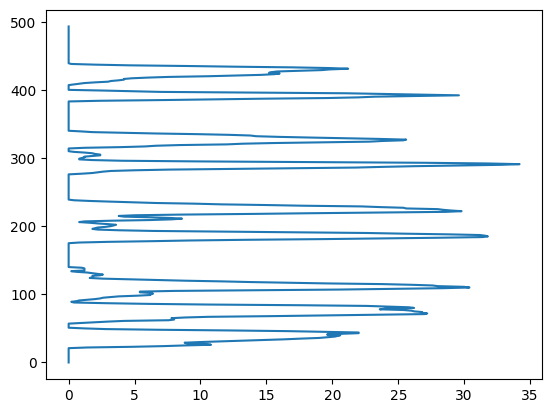

In [29]:
show(out_image)
minima_indices, firstquarter, chunk_width, final = trial_line(np.array(out_image))

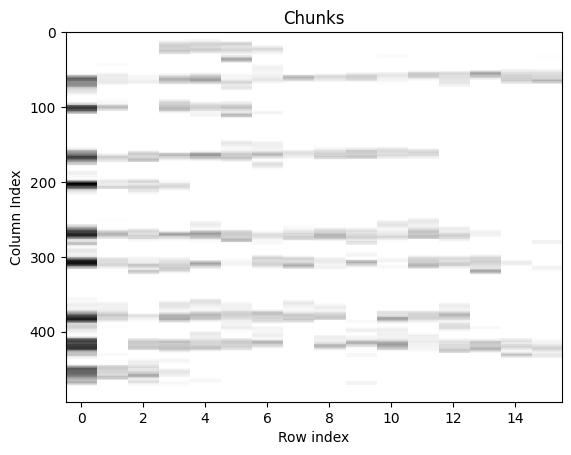

In [30]:
plt.imshow(final.T, cmap='gray_r', aspect='auto', interpolation='nearest')
plt.title('Chunks')
plt.xlabel('Row index')
plt.ylabel('Column Index')
plt.show()

In [27]:
temp = out_image.copy()
first = minima_indices[0][0]
print(first)
for i in range(len(minima_indices)):
    first = minima_indices[i][0]
    if i>0 and i<firstquarter: continue
    for j in range(len(first)-1,-1,-1):
        depth = first[j]
        if j>0 and depth-first[j-1]<15: continue
        # print(start)
        width = chunk_width if i>0 else firstquarter*chunk_width
        
        start = i*width
        end = start+width
        temp = cv2.line(np.array(temp), (start,depth), (end,depth), color=(255,0,0), thickness =1)
        # temp = cv2.line(np.array(temp), (firstquarter*chunk_width, 0), (firstquarter*chunk_width, 480), color=(255,0,0), thickness=2)
show(temp)

[ 68 278 287 297 359 366 369 393 404 415 428 452 464]


In [15]:
print(minima_indices)

[(array([ 61,  68,  70,  76, 102, 157, 162, 170, 173, 189, 193, 204, 263,
       265, 267, 272, 293, 306, 368, 371, 375, 381, 391, 400, 413, 416,
       426, 450, 452, 454, 459, 464, 466]),), (array([ 61,  65,  70,  73,  75,  78,  91,  95, 101, 105, 163, 166, 265,
       271, 291, 294, 309, 311, 379, 382, 413, 415, 420, 422, 448, 451,
       454, 459]),), (array([ 13,  58,  64, 166, 202, 206, 210, 212, 267, 272, 305, 310, 314,
       318, 379, 383, 416, 418, 447, 450, 453]),), (array([ 16,  20,  22,  32,  35,  60,  64,  97,  99, 101, 106, 164, 257,
       269, 271, 276, 281, 377, 404, 419]),), (array([ 27,  47,  60, 157, 164, 176, 277, 306, 310, 379, 382, 395, 401,
       417]),), (array([ 60, 162, 165, 266, 271, 274, 304, 310, 366, 377, 379, 384, 401,
       409, 411, 414, 416, 421]),), (array([ 58,  64, 160, 164, 255, 258, 261, 265, 270, 302, 304, 309, 382,
       385, 399, 409, 420]),), (array([ 58,  60,  63,  68, 264, 268, 304, 311, 314, 367, 372, 380, 392,
       417]),), (array([

In [24]:
line = line_segmentation(np.array(out_image))[0]
show(line)

In [60]:
def word_segmentation(line):
    def segment(img,left,right):
        height, width = img.shape
        return Image.fromarray(img).crop((left,0, right, height))  
    word_gaps = np.where(np.sum(line, axis=0)==0)[0]
    words = [0]
    for i,x in enumerate(word_gaps):
        if i == 0: continue
        if word_gaps[i]-word_gaps[i-1]>5: 
            show(segment(line, word_gaps[i-1], word_gaps[i]))
            words.append(word_gaps[i])
    
    return words
# print(word_gaps)

In [61]:
word_segmentation(np.array(line))

[0, 226, 242, 264, 276, 298, 310]

#### Verify the boxes on the image

In [60]:
final = cv2.drawContours(np.array(out_image, dtype=np.uint8),cnts, -1, (0,255,0), thickness=1, lineType=cv2.LINE_AA)
show(final)

In [52]:
final=cv2.cvtColor(np.array(out_image, dtype=np.uint8), cv2.COLOR_RGB2BGR)
for b in boundingBoxes:
    x,y,w,h = b
    final = cv2.rectangle(final, (x,y), (x+w,y+h), (0,255,0), 1)
# Image.fromarray(final).show()

In [53]:
show(final)

In [59]:
print(sorted(boundingBoxes))


[(15, 96, 23, 11), (16, 445, 79, 25), (25, 299, 23, 13), (29, 373, 26, 20), (29, 407, 14, 18), (31, 155, 11, 17), (32, 257, 11, 18), (37, 445, 21, 18), (38, 101, 7, 7), (38, 199, 17, 11), (43, 259, 22, 18), (44, 157, 19, 16), (47, 58, 25, 16), (47, 410, 10, 17), (50, 97, 37, 11), (50, 307, 7, 7), (55, 186, 7, 22), (61, 375, 12, 13), (63, 199, 13, 11), (63, 303, 24, 9), (65, 411, 18, 12), (66, 159, 16, 14), (69, 263, 13, 13), (72, 414, 24, 20), (76, 362, 19, 26), (77, 198, 8, 17), (78, 59, 24, 11), (83, 261, 22, 25), (84, 300, 4, 7), (84, 392, 9, 11), (86, 157, 19, 20), (88, 200, 16, 11), (88, 446, 15, 15), (89, 301, 10, 12), (92, 96, 9, 12), (93, 408, 13, 17), (98, 57, 10, 27), (103, 302, 13, 11), (104, 99, 17, 8), (108, 447, 15, 13), (109, 200, 15, 9), (110, 409, 7, 14), (113, 58, 17, 15), (114, 288, 10, 26), (117, 59, 6, 7), (122, 409, 23, 18), (123, 96, 11, 13), (124, 263, 24, 12), (126, 372, 13, 14), (127, 161, 21, 12), (128, 198, 26, 11), (128, 303, 28, 13), (131, 60, 10, 19), (13

In [64]:
character_images = []
for b in sorted(boundingBoxes, key=lambda x: x[1]):
    x, y, w, h = b
    character = np.array(out_image)[y:y+h, x:x+w]
    character_images.append(character)

In [67]:
show(character_images[0])height

In [12]:
templates = {}
for letter in os.listdir('alphabet'):
    png = Image.open('alphabet/'+letter) 
    background = Image.new('RGBA', png.size, (255,255,255))
    background.paste(png, mask=png.split()[3])
    background = background.convert('L')
    templates[letter[-8:-4]] = negate(background)
show(templates['3454'])

In [70]:
output_characters = []
for ch in character_images:
    best = -1
    best_char = None
    for char, template in templates.items():
        template_np = np.array(template, dtype=np.uint8)
        # ch = cv2.cvtColor(ch, cv2.COLOR_BGR2GRAY)
        ch = cv2.resize(ch, template_np.shape, interpolation=cv2.INTER_AREA)
        # show(ch)
        # print(ch.shape, template_np.shape)
        result = cv2.matchTemplate(np.array(ch, dtype=np.uint8), template_np, cv2.TM_CCOEFF_NORMED)

        match_score =np.max(result)

        if match_score > best:
            best = match_score
            best_match_char = char
        # break
    output_characters.append(best_match_char)
    # print(best_match_char, end=" ")
    # break

In [71]:
print(output_characters)

['3357', '3367', '3361', '3372', '3346', '3379', '3358', '3364', '3362', '3356', '3335', '3384', '3346', '3346', '3358', '3346', '3377', '3379', '3359', '3353', '3346', '3335', '3346', '3351', '3358', '3346', '3363', '3376', '3346', '3376', '3352', '3365', '3358', '3346', '3367', '3367', '.png', '3378', '3372', '3352', '3379', '3357', '3368', '3357', '3454', '3368', '3376', '3367', '3356', '3343', '3385', '3351', '3379', '3358', '3364', '3359', '3383', '3451', '3346', '3357', '3374', '3381', '3379', '3368', '3346', '3351', '3379', '3346', '3353', '3371', '3379', '3363', '3370', '3351', '3363', '3371', '3346', '3376', '3376', '3351', '3343', '3358', '3357', '3379', '3380', '3358', '3370', '3381', '3378', '3379', '3346', '3372', '3351', '3380', '3371', '3379', '3367', '3374', '3346', '3354', '3375', '3359', '3346', '3367', '3355', '3385', '3379', '3352', '3376', '3373', '3368', '3367', '3367', '3370', '3374', '3379', '3346', '3367', '3361', '3372', '3379', '3380', '3346', '3366', '3382',

In [73]:
for enc in output_characters:
    if enc not in encoding.encoding:
        print(enc)
        continue
    print(encoding.encoding[enc], end=" ")

ഝ ധ ഡ ബ ഒ ള ഞ ത ഢ ജ ഇ സ ഒ ഒ ഞ ഒ റ ള ട ങ ഒ ഇ ഒ ഗ ഞ ഒ ണ ര ഒ ര ഗ ഥ ഞ ഒ ധ ധ .png
ല ബ ഗ ള ഝ ന ഝ ൾ ന ര ധ ജ ഏ ഹ ഗ ള ഞ ത ട ഷ ൻ ഒ ഝ മ വ ള ന ഒ ഗ ള ഒ ങ ഫ ള ണ പ ഗ ണ ഫ ഒ ര ര ഗ ഏ ഞ ഝ ള ഴ ഞ പ വ ല ള ഒ ബ ഗ ഴ ഫ ള ധ മ ഒ ച യ ട ഒ ധ ഛ ഹ ള ഗ ര ഭ ന ധ ധ പ മ ള ഒ ധ ഡ ബ ള ഴ ഒ ദ ശ ച ഛ ൾ ധ ഗ ഗ ള ര ഹ ധ ഫ ച ഹ ള ധ സ ഝ ര ങ ധ ശ ള ര ള വ ള ഡ ര ഖ ഏ ബ ധ ബ ള യ സ ണ ള ള ഖ ട ഞ ർ ള ള ഫ ഉ പ ൽ ള ള മ ഗ ഒ ഒ ഷ യ ള ള ഢ ഭ ര ഡ ഒ ഒ ഒ ള 

In [76]:
show(character_images[6])